In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import scvi
import scipy
import random
import math
from glob import glob
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.sparsefuncs import inplace_row_scale

%matplotlib inline

Global seed set to 0


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [3]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated.h5ad")

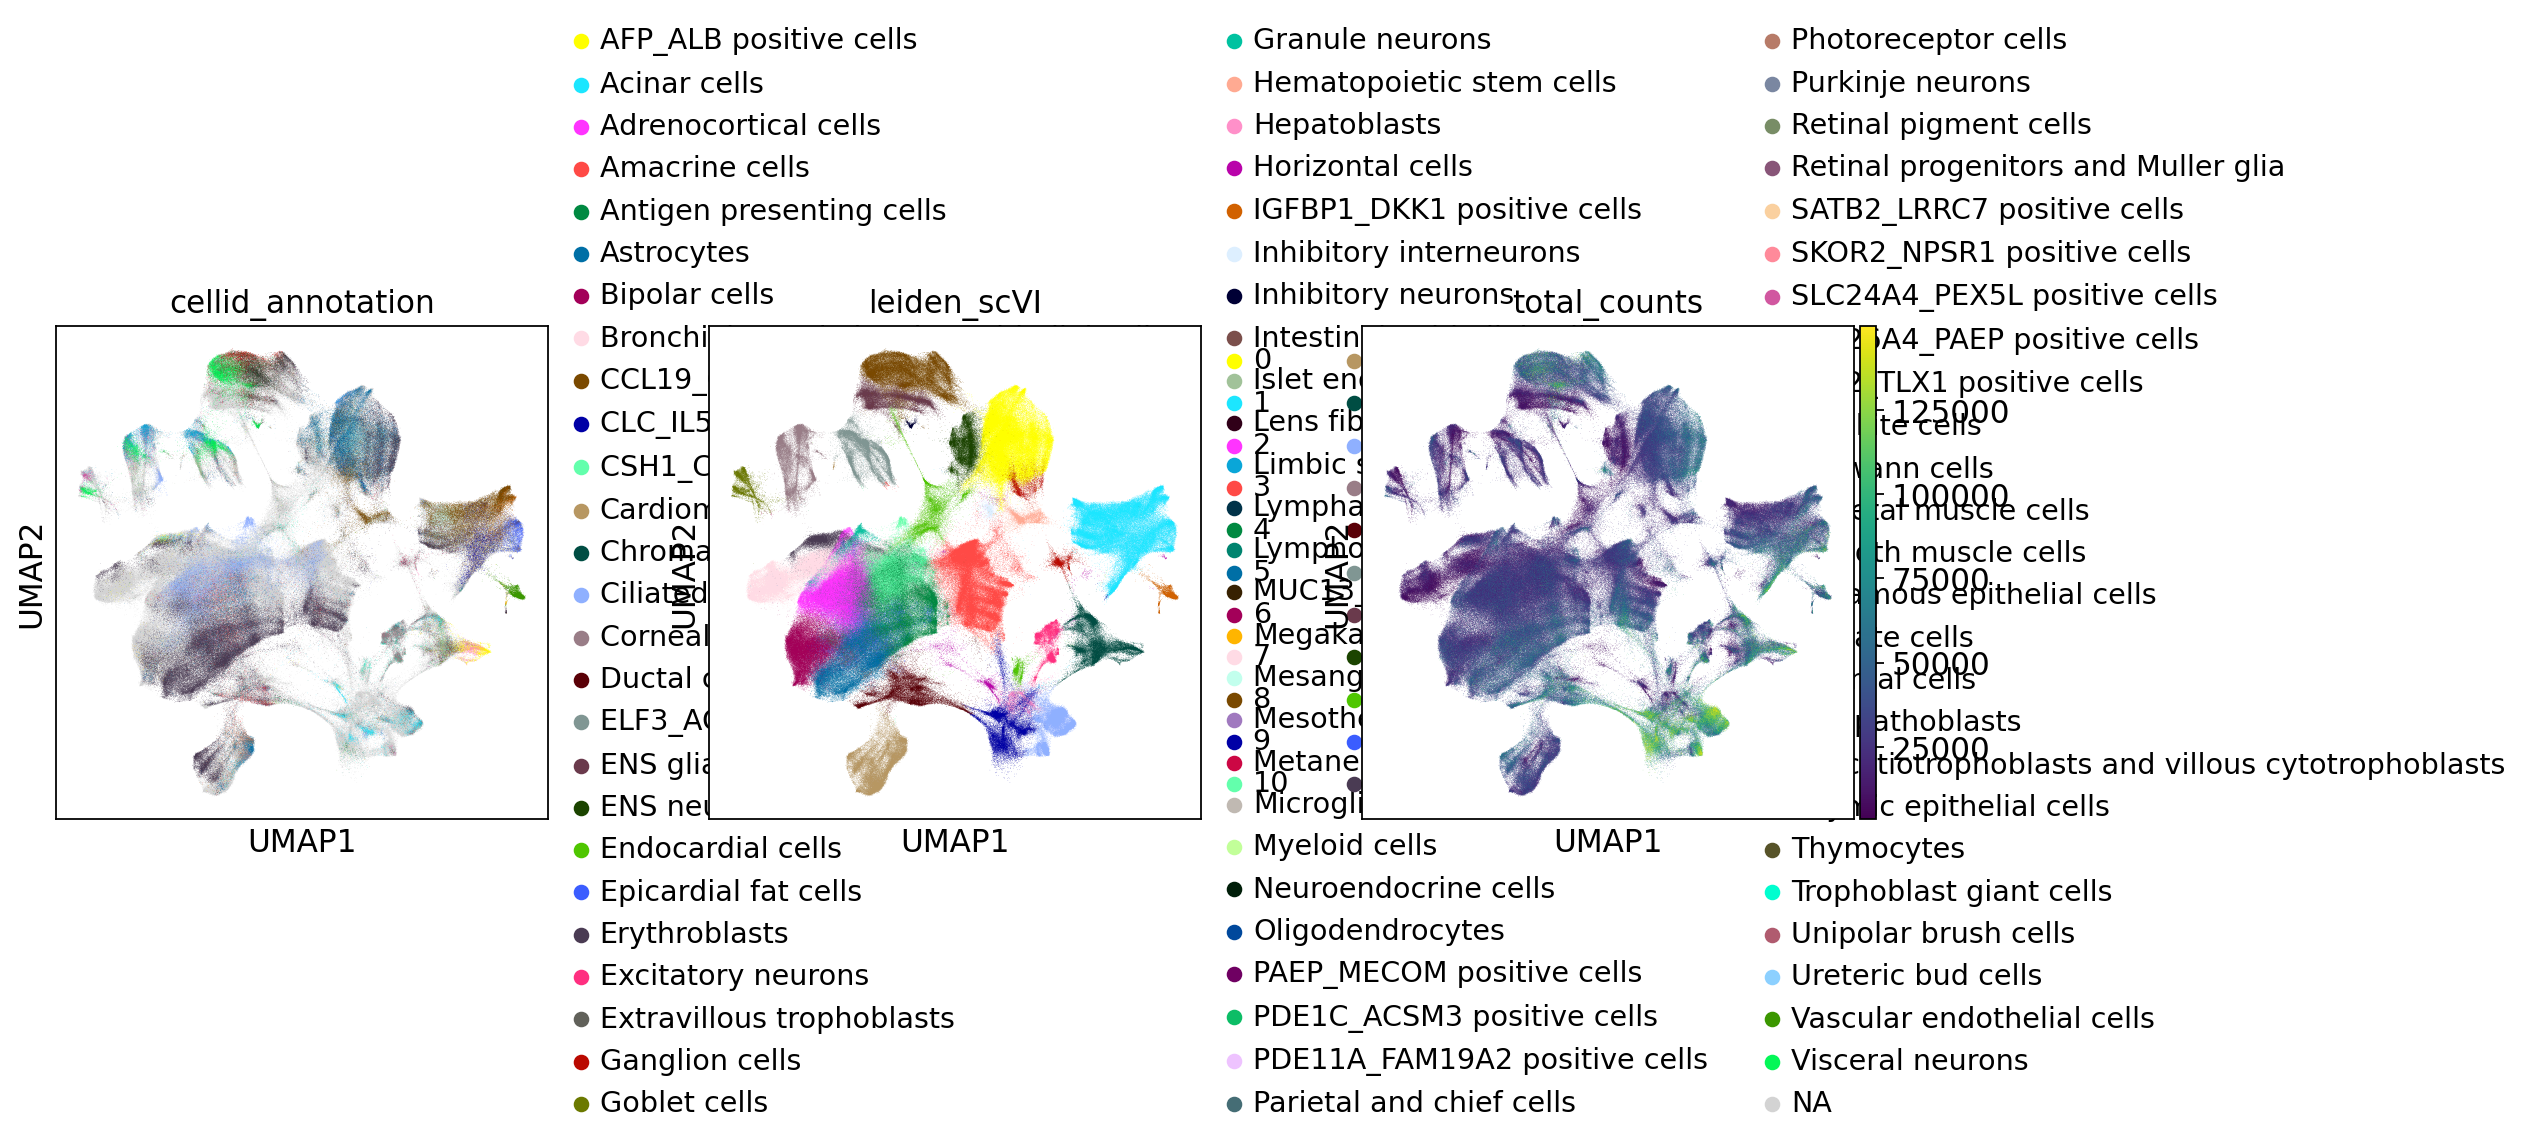

In [4]:
sc.pl.umap(adata, color=["cellid_annotation", "leiden_scVI", "total_counts"])

## Subset to a single cell type

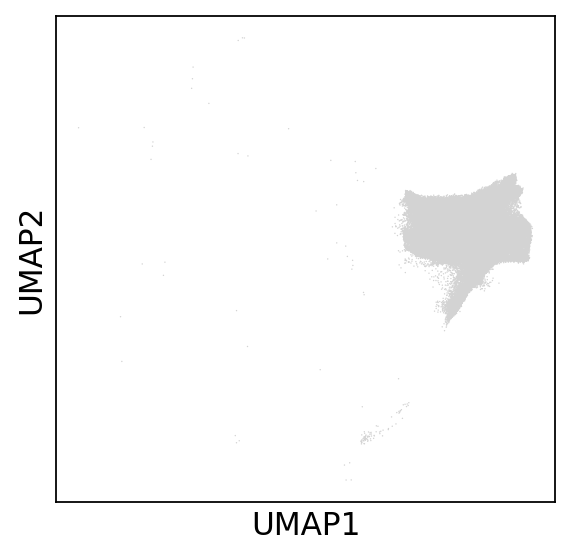

In [5]:
oneclust = adata[adata.obs['leiden_scVI'] == '1']
sc.pl.umap(oneclust)

In [6]:
oneclust = oneclust.raw.to_adata()

In [12]:
oneclust.X.data

array([1.0822055, 1.5897173, 1.0822055, ..., 2.1058676, 5.6172824,
       1.5276015], dtype=float32)

## Parameter estimation

First, assuming there's no dropout, what does the distribution of gene means look like?

In [8]:
sc.pp.calculate_qc_metrics(oneclust, inplace=True)

In [17]:
oneclust.var['log10_mean'] = np.log10(oneclust.var['mean_counts'])

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log10_mean', ylabel='Count'>

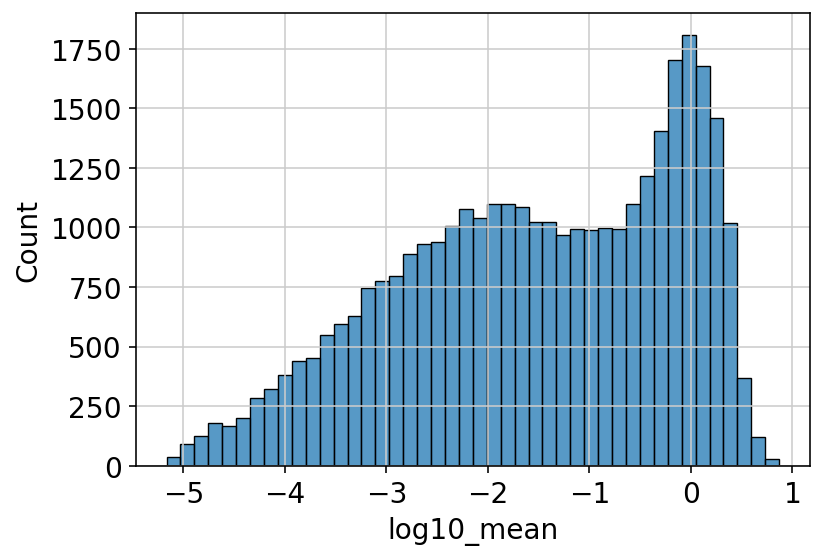

In [20]:
sns.histplot(oneclust.var, x='log10_mean')

That ain't gamma. Does the number of cells expressing a gene also appear strongly bimodal?

<AxesSubplot:xlabel='pct_dropout_by_counts', ylabel='Count'>

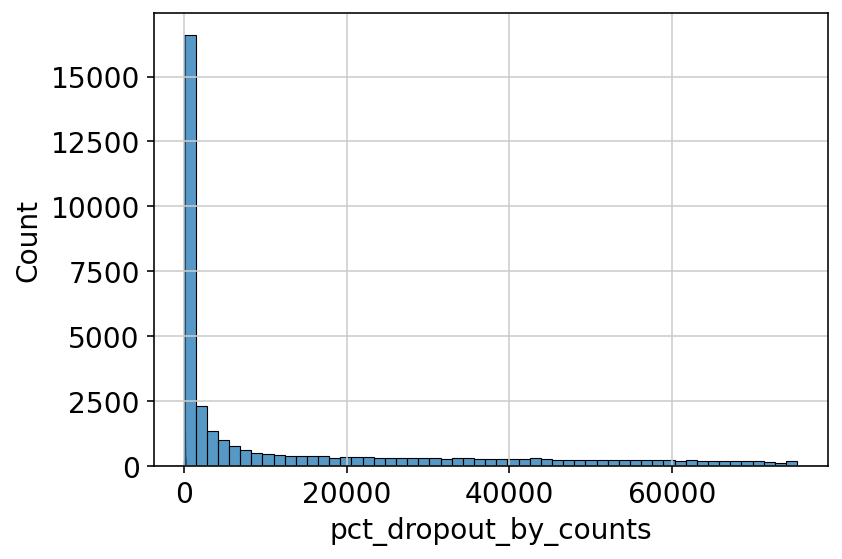

In [24]:
sns.histplot(oneclust.var, x='pct_dropout_by_counts')
#sns.histplot(oneclust.var, x='n_cells_by_counts')

No, these look fairly normal. Does the distribution of library sizes look normal?

<AxesSubplot:xlabel='total_counts', ylabel='Count'>

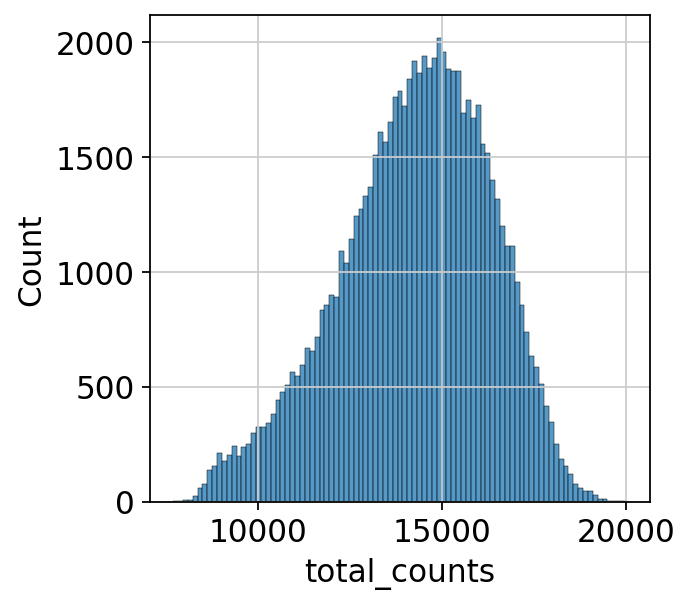

In [9]:
sns.histplot(oneclust.obs, x='total_counts')

<AxesSubplot:xlabel='log_total_counts', ylabel='Count'>

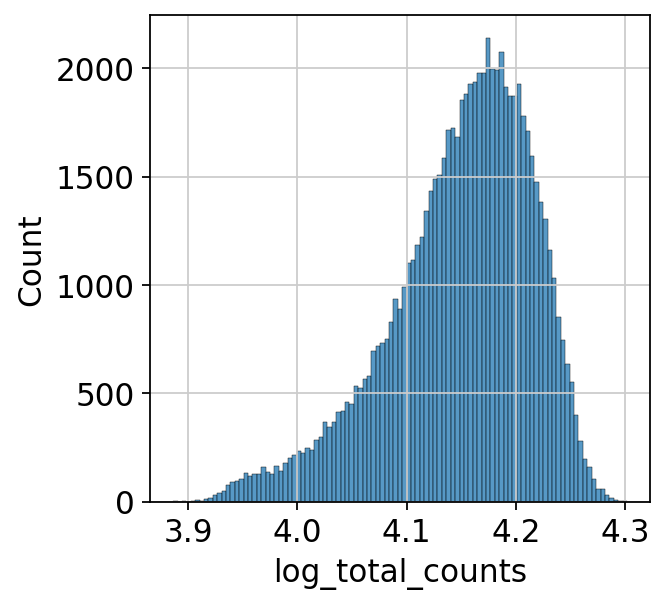

In [11]:
oneclust.obs['log_total_counts'] = np.log10(oneclust.obs['total_counts'])
sns.histplot(oneclust.obs, x='log_total_counts')

What could cause this distribution? Could it vary by batch or individual, perhaps? Is this unique to the cellular population we chose or do we see something similar in other 'cell types'

### Examining alternative cell types

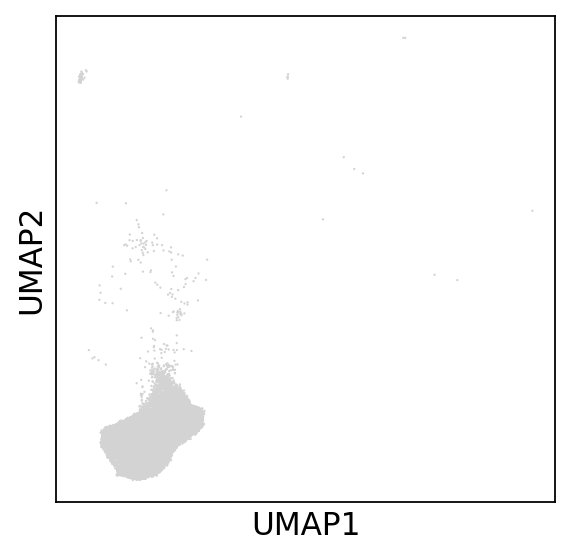

In [12]:
otherclust = adata[adata.obs['leiden_scVI'] == '11']
sc.pl.umap(otherclust)

Trying to set attribute `.obs` of view, copying.
/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log10_mean', ylabel='Count'>

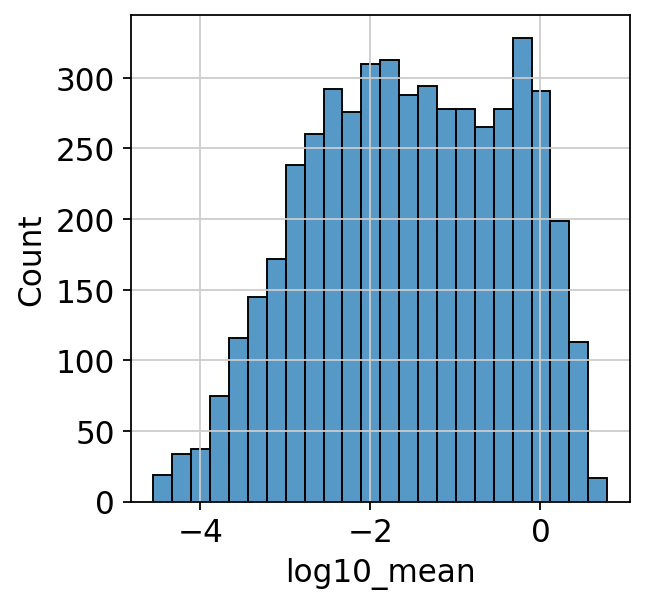

In [13]:
sc.pp.calculate_qc_metrics(otherclust, inplace=True)
otherclust.var['log10_mean'] = np.log10(otherclust.var['mean_counts'])
sns.histplot(otherclust.var, x='log10_mean')

<AxesSubplot:xlabel='total_counts', ylabel='Count'>

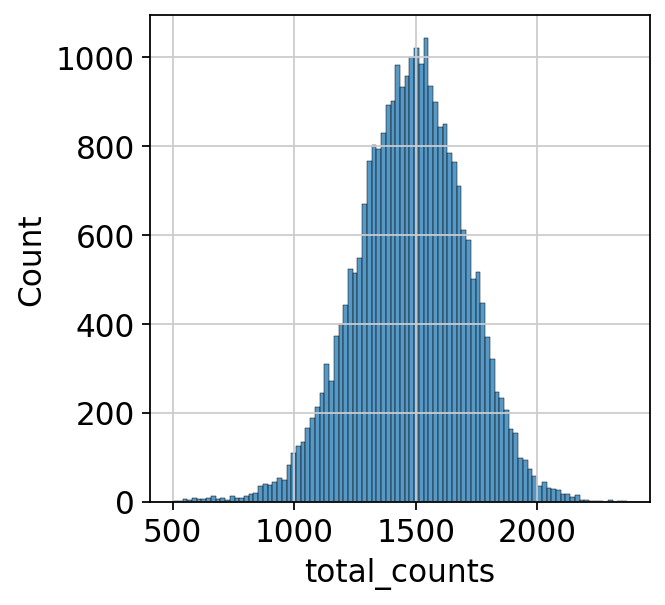

In [15]:
sns.histplot(otherclust.obs, x='total_counts')

<AxesSubplot:xlabel='log_total_counts', ylabel='Count'>

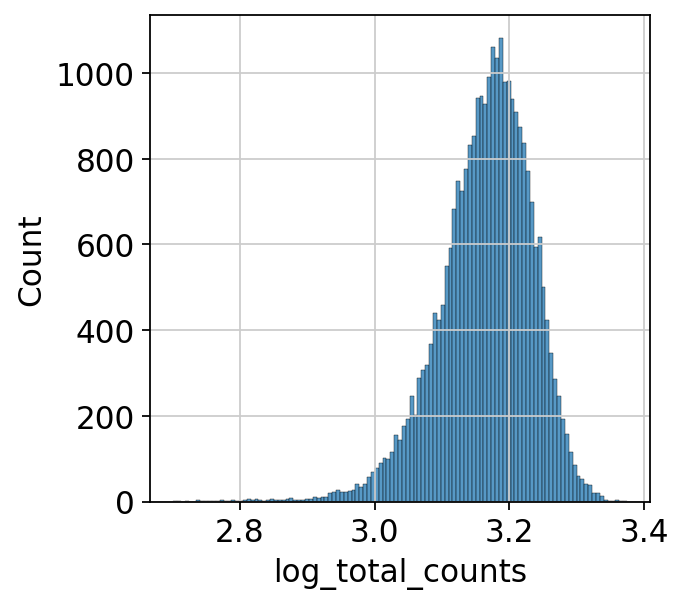

In [14]:
otherclust.obs['log_total_counts'] = np.log10(otherclust.obs['total_counts'])
sns.histplot(otherclust.obs, x='log_total_counts')

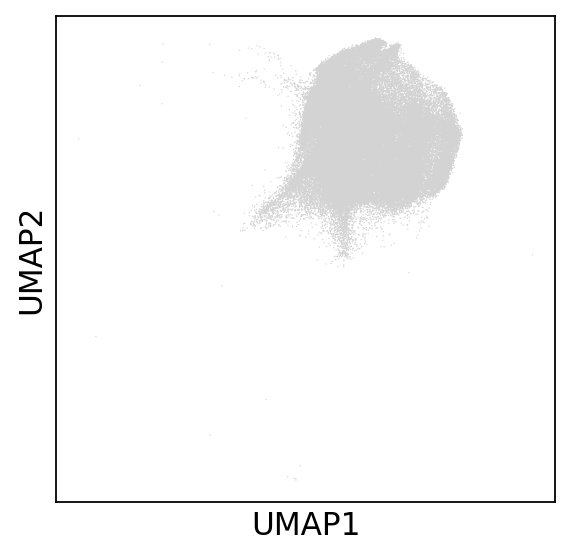

In [16]:
thirdclust = adata[adata.obs['leiden_scVI'] == '0']
sc.pl.umap(thirdclust)

Trying to set attribute `.obs` of view, copying.
/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log10_mean', ylabel='Count'>

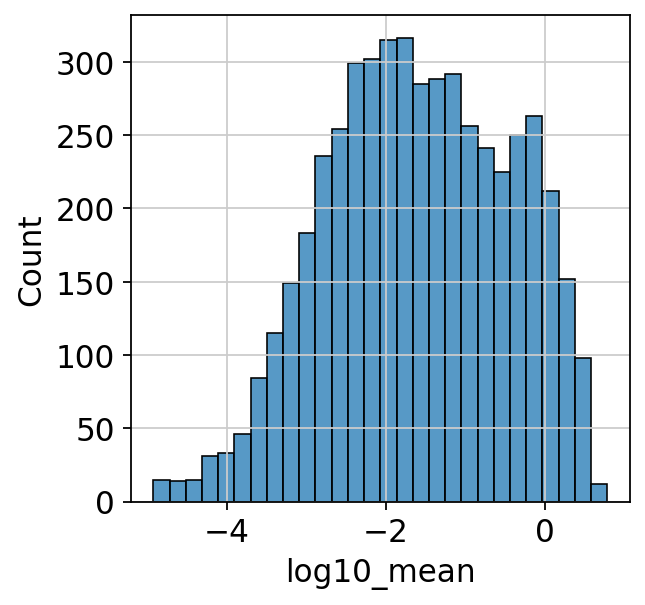

In [17]:
sc.pp.calculate_qc_metrics(thirdclust, inplace=True)
thirdclust.var['log10_mean'] = np.log10(thirdclust.var['mean_counts'])
sns.histplot(thirdclust.var, x='log10_mean')

<AxesSubplot:xlabel='total_counts', ylabel='Count'>

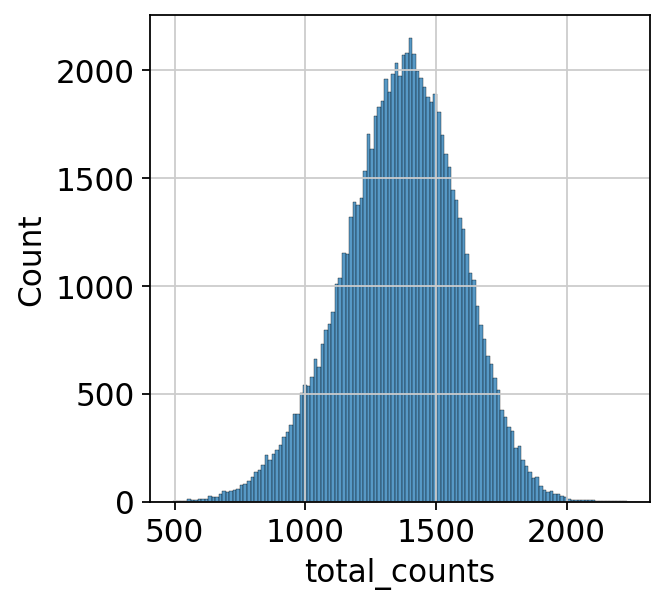

In [18]:
sns.histplot(thirdclust.obs, x='total_counts')

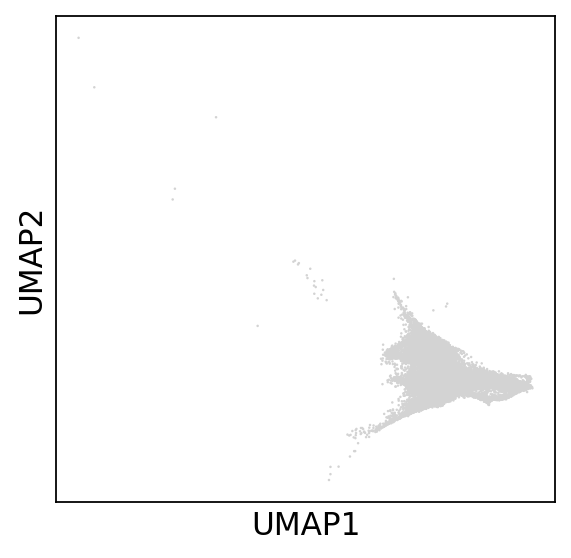

In [20]:
fourthclust = adata[adata.obs['leiden_scVI'] == '12']
sc.pl.umap(fourthclust)

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log10_mean', ylabel='Count'>

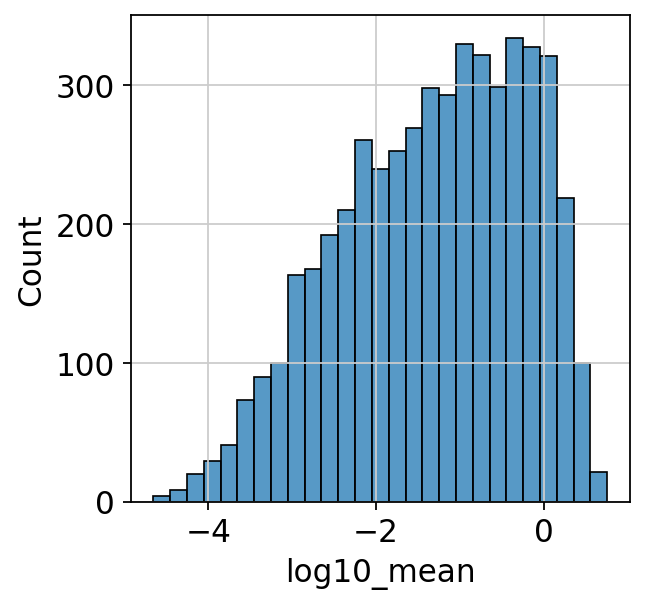

In [27]:
sc.pp.calculate_qc_metrics(fourthclust, inplace=True)
fourthclust.var['log10_mean'] = np.log10(fourthclust.var['mean_counts'])
sns.histplot(fourthclust.var, x='log10_mean')

<AxesSubplot:xlabel='total_counts', ylabel='Count'>

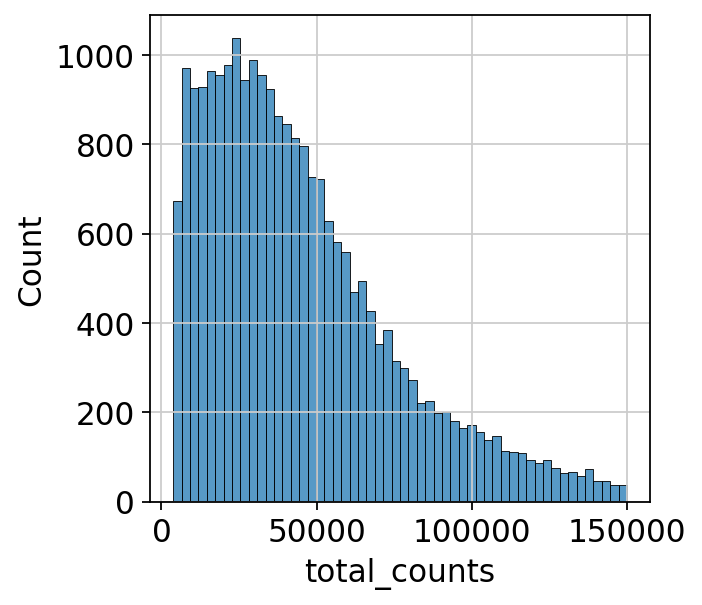

In [21]:
sns.histplot(fourthclust.obs, x='total_counts')

Trying to set attribute `.obs` of view, copying.


<AxesSubplot:xlabel='log_total_counts', ylabel='Count'>

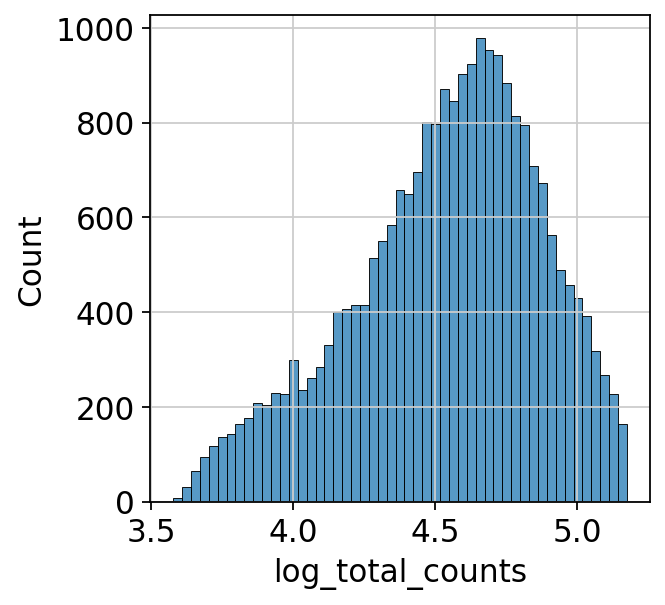

In [22]:
fourthclust.obs['log_total_counts'] = np.log10(fourthclust.obs['total_counts'])
sns.histplot(fourthclust.obs, x='log_total_counts')

A few observations here.
1. For the less proliferative cell types, library size appears normally distributed, and for the more proliferative cell type (the fourth one, which has more partially differentiated cells), it's closer to log normal.
2. The distribution of gene means appears to be bimodal in most cases, with one group of genes having mode log mean expression at about -2, one group of genes having mode log mean expression closer to 0. 

### Downsampling to 5k genes for simulation

To more conveniently approximate a simulation setting, I want to go down to 5K genes and explore these same distributions

In [42]:
gene_subset = random.sample(range(oneclust.shape[1]), 5000)

In [44]:
oneclust_5kgenes = oneclust[:, gene_subset]

In [53]:
sc.pp.calculate_qc_metrics(oneclust_5kgenes, inplace=True)

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log10_mean', ylabel='Count'>

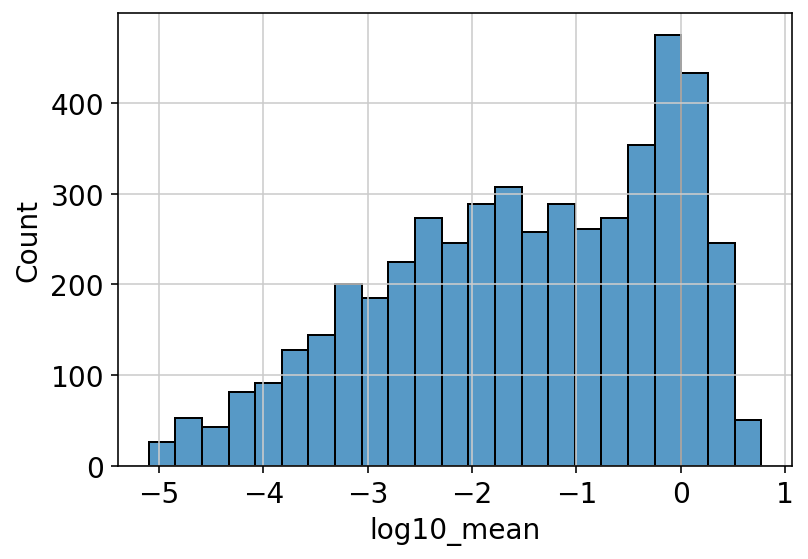

In [54]:
oneclust_5kgenes.var['log10_mean'] = np.log10(oneclust_5kgenes.var['mean_counts'])
sns.histplot(oneclust_5kgenes.var, x='log10_mean')

<AxesSubplot:xlabel='total_counts', ylabel='Count'>

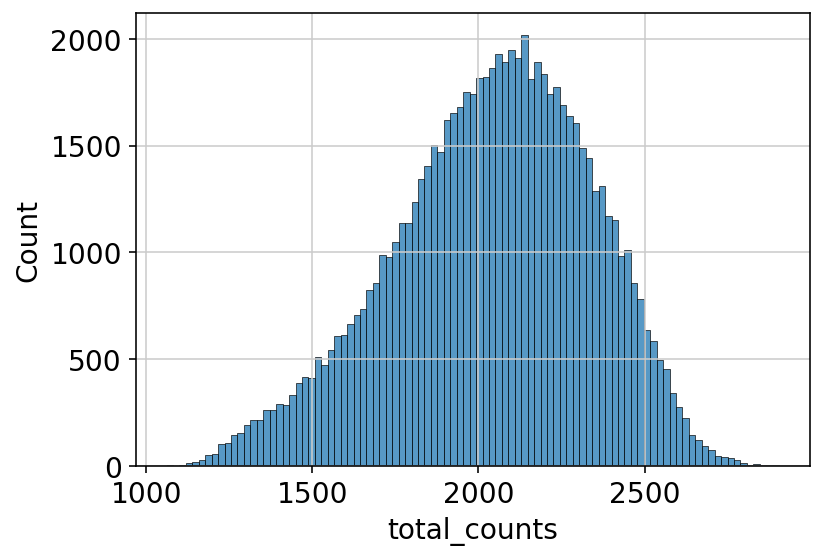

In [55]:
sns.histplot(oneclust_5kgenes.obs, x='total_counts')

In [56]:
np.mean(oneclust_5kgenes.obs['total_counts'])

2040.119

In [64]:
np.std(oneclust_5kgenes.obs['total_counts'])

298.76727

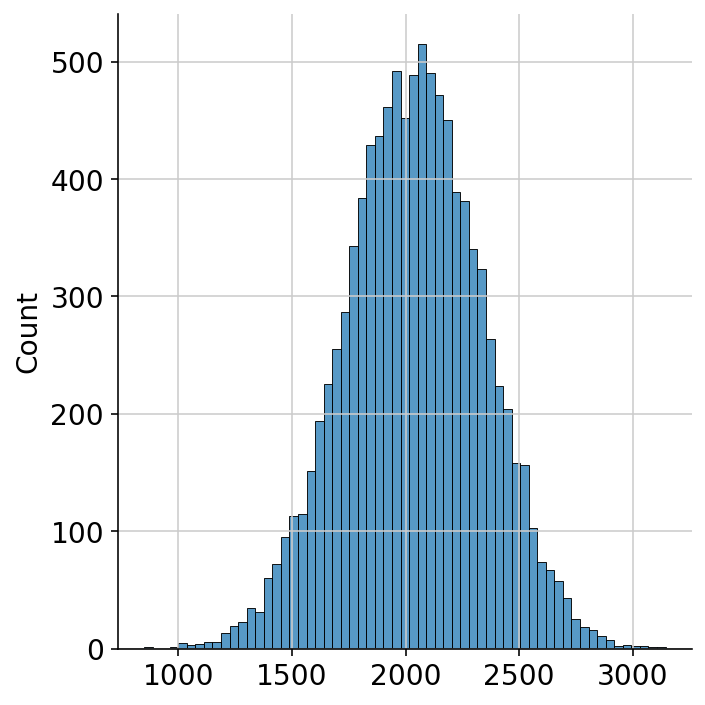

In [65]:
sns.displot(np.random.normal(loc=2040, scale=300, size=10000))

I'm going to save these counts to a tsv file, and use that to see if `splat` is able to model that trend I'm seeing in the distribution of gene means.

** PROBLEM ** these are not raw counts!!

In [66]:
counts = oneclust_5kgenes.X

In [72]:
scipy.io.mmwrite("/project2/gilad/jpopp/ebQTL/temp/meso_5kgenes_counts.mm", counts)

In [93]:
gene_names=pd.DataFrame(oneclust_5kgenes.var.index.tolist(), columns=["gene"])
gene_names.to_csv("/project2/gilad/jpopp/ebQTL/temp/meso_5kgenes_counts.gene_names.tsv", sep="\t", index=False)

In [94]:
cell_names=pd.DataFrame(oneclust_5kgenes.obs.index.tolist(), columns=["cell"])
cell_names.to_csv("/project2/gilad/jpopp/ebQTL/temp/meso_5kgenes_counts.cell_names.tsv", sep="\t", index=False)

### Does the same trend arise from library-size normalized count data?

In [22]:
scran_adata = sc.read_h5ad("/project2/gilad/ktayeb/ebqtl-workflowr/output/proc/EB_high_pass_filtered_normalized.h5ad")

In [23]:
gene_names = pd.read_csv("/project2/gilad/jpopp/ebQTL/temp/meso_5kgenes_counts.gene_names.tsv", sep="\t")
cell_names = pd.read_csv("/project2/gilad/jpopp/ebQTL/temp/meso_5kgenes_counts.cell_names.tsv", sep="\t")

In [24]:
oneclust_5kgenes_scran = scran_adata[cell_names['cell'], gene_names['gene']]

In [43]:
alterable = oneclust_5kgenes_scran.copy()

In [32]:
def log1pnormalized2counts(adata, scale_by='sizeFactor'):
    adata.X.data = np.exp(adata.X.data) - 1  # undo log1
    inplace_row_scale(adata.X, adata.obs[scale_by].values)  # tocounts
    adata.X.data = adata.X.data.astype(int)

In [47]:
log1pnormalized2counts(alterable, scale_by='sizeFactor')

In [49]:
scipy.io.mmwrite("/project2/gilad/jpopp/ebQTL/temp/meso_5kgenes_counts", alterable.X)

Trying to set attribute `.obs` of view, copying.
/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log10_mean', ylabel='Count'>

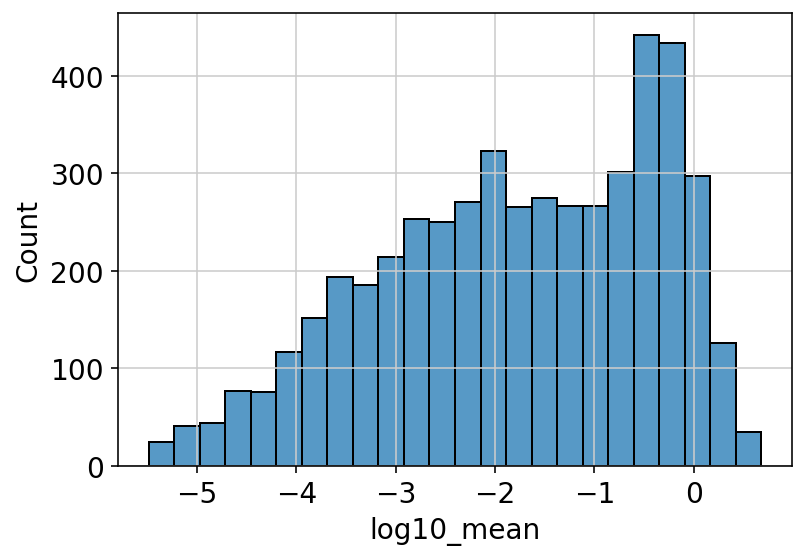

In [16]:
sc.pp.calculate_qc_metrics(oneclust_5kgenes_scran, inplace=True)
oneclust_5kgenes_scran.var['log10_mean'] = np.log10(oneclust_5kgenes_scran.var['mean_counts'])
sns.histplot(oneclust_5kgenes_scran.var, x='log10_mean')

Yes, it's not just a matter of library size normalization it doesn't look like. ** WRONG ** I failed to answer this question, without the size factor these are raw counts. It's only slightly different bc some samples were removed

## Does subsetting to a single individual change anything?

In [17]:
oneclust_5kgenes_scran.obs[['donor_id']].value_counts()

donor_id
NA18489     9705
NA19130     5113
NA18516     4790
NA18517     4743
NA18522     3737
NA19204     3517
NA19093     3476
NA19160     3068
NA19193     3038
NA19225     2985
NA18855     2538
NA18856     2290
NA18912     2189
NA19207     1836
NA19098     1806
NA19102     1671
NA18502     1599
NA19108     1487
NA18508     1460
NA19128     1444
NA18501     1286
NA18511     1228
NA19140     1190
NA19143      961
NA18520      935
NA18862      843
NA19257      840
NA18510      541
NA18499      528
NA19152      521
NA19099      496
NA18507      488
NA19190      397
NA19127      325
NA18486      301
NA18870      273
NA19203      262
NA18505      253
NA18519      250
NA19159      234
NA19119      166
NA19210      151
NA19153      104
NA19116       95
NA18498       89
NA19144       84
NA18913       54
NA19114       24
NA19209        4
NA19101        1
dtype: int64

In [50]:
oneclust_5kgenes_scran_oneind = alterable[alterable.obs['donor_id'] == 'NA18489']

Trying to set attribute `.obs` of view, copying.
/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log10_mean', ylabel='Count'>

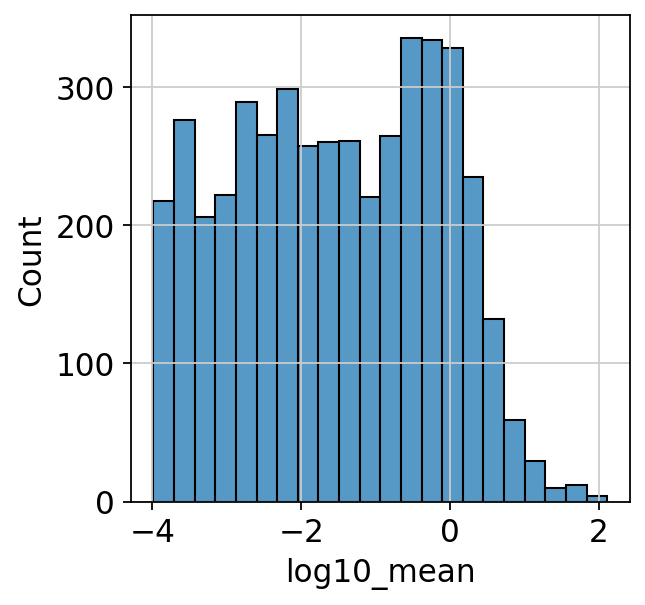

In [51]:
sc.pp.calculate_qc_metrics(oneclust_5kgenes_scran_oneind, inplace=True)
oneclust_5kgenes_scran_oneind.var['log10_mean'] = np.log10(oneclust_5kgenes_scran_oneind.var['mean_counts'])
sns.histplot(oneclust_5kgenes_scran_oneind.var, x='log10_mean')

Once again this seems to have little impact on the distribution of gene means - this means I should be able to get away with using the smaller number of cells to estimate the single cell parameters with `splat`.

In [52]:
scipy.io.mmwrite("/project2/gilad/jpopp/ebQTL/temp/meso_5kgenes_oneind_counts", oneclust_5kgenes_scran_oneind.X)